# SIMPET runs analysis

In [149]:
import yaml
import json
import wandb
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from pyprojroot import here
from randfig.utils import get_divisors

In [150]:
def select_cfgs_only_differ_in_params(base_cfg, cfgs, diff_params):
    """
    # TODO.

    Args:

    Returns:

    """
    

## Download configs from WANDB

In [151]:
SAVE_CONFIGS_PATH = here().joinpath("wandb_simpet_experiments_configs")
SAVE_CONFIGS_PATH.mkdir(parents=True, exist_ok=True)

api = wandb.Api()
configs = {run.name: [file for file in run.files() if file.name == "config.yaml"][0] for run in api.runs(path="fisikillo/SimPET-Randfigs-Simulations")}

for name, cfg in configs.items():
    if name != "GE Discovery ST":
        name = "".join(name.split(" ")[0:2])
    else:
        name = "".join(name.split(" ")[0:3])
    path = SAVE_CONFIGS_PATH.joinpath(name)
    cfg.download(path, replace=True)

In [152]:
run_info = [{
    "NAME": run.name,
    "ID": run.id,
    "RUN": run,
} for run in api.runs(path="fisikillo/SimPET-Randfigs-Simulations")]

run_info[-1]

for run in run_info:
    try:
        run.update({"N": int(run["NAME"].split(" ")[-1])})
    except ValueError:
        run.update({"N": 0})

In [153]:
METADATA_NAME = 'Outputs.table.json'
PARAMS_OF_INTEREST = {"scanner_radius", "zoomFactor", "xyOutputSize", "psf_value", "numberOfIterations"}

for run in run_info:
    Outputs_artifact = api.artifact(name=f"fisikillo/SimPET-Randfigs-Simulations/run-{run['ID']}-Outputs:latest")
    metadata = [f for f in Outputs_artifact.files() if f.name == METADATA_NAME].pop()
    xd = [f.name for f in Outputs_artifact.files()]
    
    save_artifacts_path = Path(f"/tmp/wandb/{run['NAME'].replace(' ', '')}")
    metadata.download(save_artifacts_path, replace=True)

    with open(save_artifacts_path.joinpath(METADATA_NAME), 'r') as mdata:
        metadata = json.load(mdata)
    
    rec_idx = [i for i, name in enumerate(metadata["columns"]) if name.startswith("rec_")].pop()
    rec_name = metadata["data"].pop()[rec_idx]["path"]

    rec_file = [f for f in Outputs_artifact.files() if f.name == rec_name].pop()
    rec_file.download(save_artifacts_path, replace=True)
    
    rec_path = save_artifacts_path.joinpath(rec_file.name)
    run.update({**{"REC": rec_path}, **{k: v for k, v in run["RUN"].config["params"]["scanner"].items() if k in PARAMS_OF_INTEREST}})


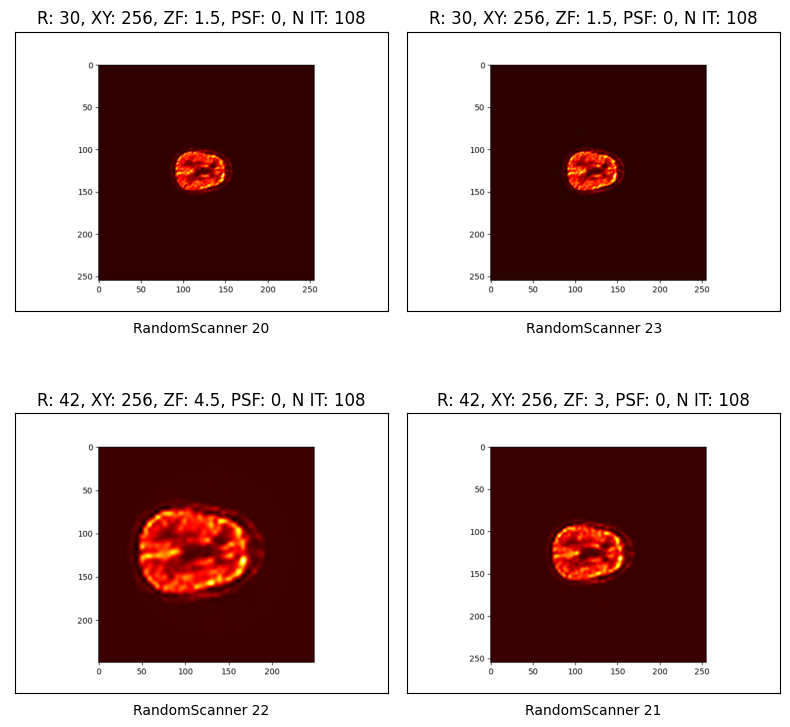

In [154]:
RUN_CUTOFF = 20
runs_of_interest = [run for run in run_info if run["N"] >= RUN_CUTOFF]

N = len(runs_of_interest)
divisors = [n for n in get_divisors(N) if n not in {1}]

NROWS = divisors[0]
NCOLS = N // NROWS


fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(8, 8))

for img, axis in zip(run_info, ax.flatten()):
    axis.imshow(Image.open(img["REC"]))
    axis.set_title(f"R: {int(img['scanner_radius'])}, XY: {img['xyOutputSize']}, ZF: {img['zoomFactor']}, PSF: {img['psf_value']}, N IT: {img['numberOfIterations']}")
    axis.set_xlabel(img["NAME"])
    axis.set_xticks([])
    axis.set_yticks([])

fig.tight_layout()


## Read configs

In [119]:
configs = {}
REF_SCANNER = "GEDiscoveryST"

for cfg in SAVE_CONFIGS_PATH.rglob("**/*.yaml"):
    with open(cfg, 'r') as cfg_file:
        configs.update({cfg.parent.name: yaml.safe_load(cfg_file)})

scanner_configs = {name: cfg["params"]["value"]["scanner"] for name, cfg in configs.items()}
REF_CONFIG = scanner_configs.pop(REF_SCANNER)

## Show which parameters are different from a ref config that works
The idea is to take a scanner configuration of reference (GE Discovery ST) and gradually replace parameters for the randomized ones.

In [120]:
params_different_from_ref_config = {}

for name, s_cfg in scanner_configs.items():
    params_different = {k: f"{REF_CONFIG[k]}, {v}" + f"{(' D' if REF_CONFIG[k] != v else ' E')}" for k, v in s_cfg.items()}
    params_different_from_ref_config[name] = params_different

### Ref config (GE Discovery ST)

In [121]:
ref_cfg_df = pd.DataFrame([REF_CONFIG]).set_index("scanner_name").transpose()
ref_cfg_df.index.names = ["Parameters"]
ref_cfg_df

scanner_name,GE Discovery ST
Parameters,
simset_material,10
average_doi,0.84
scanner_radius,44.31
num_rings,24
axial_fov,15.7
z_crystal_size,0.63
transaxial_crystal_size,0.63
crystal_thickness,3
energy_resolution,16


### Parameters Diff
The following data frame shows which parameters are different from the reference scanner (GE Discovery ST), ending with D, and which ones are equal, ending with E.

In [122]:
scanner_df = pd.DataFrame([{**scanner_cfg, **{"scanner_name": name}} for name, scanner_cfg in params_different_from_ref_config.items()])
new_idx = sorted([sname for sname in scanner_df["scanner_name"]], key=lambda name: int(name.split("RandomScanner")[-1]))
new_idx.reverse()
ordered_scanner_df = scanner_df.set_index("scanner_name").loc[new_idx, ].transpose()
ordered_scanner_df.index.names = ["Parameters"]

# Show only incrmental configurations
n_cols = ordered_scanner_df.shape[-1]
configs_of_interest = ordered_scanner_df[[f"RandomScanner{i}" for i in reversed(range(4, n_cols))]]
configs_of_interest


scanner_name,RandomScanner23,RandomScanner22,RandomScanner21,RandomScanner20,RandomScanner19,RandomScanner18,RandomScanner17,RandomScanner16,RandomScanner15,RandomScanner14,RandomScanner13,RandomScanner12,RandomScanner11,RandomScanner10,RandomScanner9,RandomScanner8,RandomScanner7,RandomScanner6,RandomScanner5,RandomScanner4
Parameters,,,,,,,,,,,,,,,,,,,,
simset_material,"10, 10 D","10, 10 D","10, 10 D","10, 10 D","10, 29 D","10, 29 D","10, 29 D","10, 29 D","10, 18 D","10, 18 D","10, 18 D","10, 18 D","10, 18 D","10, 18 D","10, 10 E","10, 10 E","10, 10 E","10, 10 E","10, 10 E","10, 10 E"
average_doi,"0.84, 1.05 D","0.84, 1.05 D","0.84, 1.05 D","0.84, 1.05 D","0.84, 1.2 D","0.84, 1.2 D","0.84, 1.2 D","0.84, 1.2 D","0.84, 1.16 D","0.84, 1.16 D","0.84, 1.16 D","0.84, 1.16 D","0.84, 1.16 D","0.84, 1.16 D","0.84, 1.05 D","0.84, 1.05 D","0.84, 0.84 E","0.84, 0.84 E","0.84, 0.84 E","0.84, 0.84 E"
scanner_radius,"44.31, 30 D","44.31, 42.496 D","44.31, 42.496 D","44.31, 42.496 D","44.31, 40 D","44.31, 32.933 D","44.31, 32.933 D","44.31, 32.933 D","44.31, 38.25 D","44.31, 38.25 D","44.31, 38.25 D","44.31, 38.25 D","44.31, 38.25 D","44.31, 38.25 D","44.31, 42.51 D","44.31, 42.51 D","44.31, 42.51 D","44.31, 42.51 D","44.31, 42.51 D","44.31, 42.51 D"
num_rings,"24, 28 D","24, 28 D","24, 28 D","24, 28 D","24, 24 E","24, 24 E","24, 24 E","24, 24 E","24, 48 D","24, 48 D","24, 48 D","24, 48 D","24, 48 D","24, 48 D","24, 41 D","24, 41 D","24, 41 D","24, 24 E","24, 24 E","24, 24 E"
axial_fov,"15.7, 22.05 D","15.7, 22.05 D","15.7, 22.05 D","15.7, 22.05 D","15.7, 17.162 D","15.7, 17.162 D","15.7, 17.162 D","15.7, 17.162 D","15.7, 22.01 D","15.7, 22.01 D","15.7, 22.01 D","15.7, 22.01 D","15.7, 22.01 D","15.7, 22.01 D","15.7, 17.43 D","15.7, 17.43 D","15.7, 17.43 D","15.7, 17.43 D","15.7, 17.43 D","15.7, 15.7 E"
z_crystal_size,"0.63, 0.746 D","0.63, 0.746 D","0.63, 0.746 D","0.63, 0.746 D","0.63, 0.689 D","0.63, 0.689 D","0.63, 0.689 D","0.63, 0.689 D","0.63, 0.45 D","0.63, 0.45 D","0.63, 0.45 D","0.63, 0.45 D","0.63, 0.45 D","0.63, 0.45 D","0.63, 0.41 D","0.63, 0.41 D","0.63, 0.41 D","0.63, 0.41 D","0.63, 0.41 D","0.63, 0.63 E"
transaxial_crystal_size,"0.63, 0.494 D","0.63, 0.494 D","0.63, 0.494 D","0.63, 0.494 D","0.63, 0.464 D","0.63, 0.464 D","0.63, 0.464 D","0.63, 0.464 D","0.63, 0.4 D","0.63, 0.4 D","0.63, 0.4 D","0.63, 0.4 D","0.63, 0.4 D","0.63, 0.4 D","0.63, 0.6 D","0.63, 0.6 D","0.63, 0.6 D","0.63, 0.6 D","0.63, 0.6 D","0.63, 0.6 D"
crystal_thickness,"3, 2.715 D","3, 2.715 D","3, 2.715 D","3, 2.715 D","3, 1.916 D","3, 1.916 D","3, 1.916 D","3, 1.916 D","3, 2.93 D","3, 2.93 D","3, 2.93 D","3, 2.93 D","3, 2.93 D","3, 2.93 D","3, 2.02 D","3, 2.02 D","3, 2.02 D","3, 3 E","3, 3 E","3, 3 E"
energy_resolution,"16, 12.196 D","16, 12.196 D","16, 12.196 D","16, 12.196 D","16, 10.011 D","16, 10.011 D","16, 10.011 D","16, 10.011 D","16, 12.61 D","16, 12.61 D","16, 12.61 D","16, 12.61 D","16, 12.61 D","16, 12.61 D","16, 13.69 D","16, 16 E","16, 16 E","16, 16 E","16, 16 E","16, 16 E"


In [123]:
for col in configs_of_interest.columns:
    scanner = ordered_scanner_df[col]
    print(
        f"{col}: different to {REF_SCANNER}", '\n', 
        scanner[scanner.str.endswith("D").fillna(False)], 
        '\n\n',
        f"{col}: equal to {REF_SCANNER}", '\n', 
        scanner[scanner.str.endswith("E").fillna(False)], 
        '\n\n'
    )

RandomScanner23: different to GEDiscoveryST 
 Parameters
simset_material                       10, 10 D
average_doi                       0.84, 1.05 D
scanner_radius                     44.31, 30 D
num_rings                             24, 28 D
axial_fov                        15.7, 22.05 D
z_crystal_size                   0.63, 0.746 D
transaxial_crystal_size          0.63, 0.494 D
crystal_thickness                   3, 2.715 D
energy_resolution                 16, 12.196 D
num_aa_bins                         210, 270 D
num_td_bins                         249, 140 D
min_energy_window               375, 456.525 D
max_energy_window               675, 571.195 D
coincidence_window               11.7, 11.35 D
numberOfSubsets                         7, 9 D
numberOfIterations                   32, 108 D
savingInterval                        8, 108 D
analytical_att_correction               0, 1 D
stir_recons_att_corr                    1, 0 D
analytic_scatt_corr_factor        0.15, 0.35 D
ana

In [124]:
prev = None
for i, col in enumerate(reversed(configs_of_interest.columns)):
    if prev is not None:
        ref_scanner = configs_of_interest[prev].fillna("Not set")
        scanner = ordered_scanner_df[col].fillna("Not set")
        print(
            f"{prev} => {col}\n",
            scanner[~ref_scanner.eq(scanner)],
            "\n\n"
        )
    prev = col

RandomScanner4 => RandomScanner5
 Parameters
axial_fov         15.7, 17.43 D
z_crystal_size     0.63, 0.41 D
Name: RandomScanner5, dtype: object 


RandomScanner5 => RandomScanner6
 Parameters
num_aa_bins        210, 225 D
num_td_bins        249, 117 D
numberOfSubsets        7, 9 D
Name: RandomScanner6, dtype: object 


RandomScanner6 => RandomScanner7
 Parameters
num_rings             24, 41 D
crystal_thickness    3, 2.02 D
Name: RandomScanner7, dtype: object 


RandomScanner7 => RandomScanner8
 Parameters
average_doi    0.84, 1.05 D
max_segment        23, 31 D
Name: RandomScanner8, dtype: object 


RandomScanner8 => RandomScanner9
 Parameters
energy_resolution      16, 13.69 D
min_energy_window    375, 452.61 D
max_energy_window    675, 569.87 D
Name: RandomScanner9, dtype: object 


RandomScanner9 => RandomScanner10
 Parameters
simset_material                  10, 18 D
average_doi                  0.84, 1.16 D
scanner_radius             44.31, 38.25 D
num_rings                      